## 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_pil_image # tensor to pil_image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [2]:
# 데이터셋 폴더 경로를 지정
train_dir = '../input/data/train'
test_dir = '../input/data/eval'

In [3]:
train_csv = pd.read_csv(os.path.join(train_dir, 'train.csv'))

# drop id, race column
train_csv = train_csv.drop(['id', 'race'], axis=1)
print(len(train_csv))
train_csv.tail(3)

2700


,gender,age,path
2697,male,19,006956_male_Asian_19
2698,male,20,006957_male_Asian_20
2699,male,19,006959_male_Asian_19


In [4]:
def encode_y(mask, gender, age):
    if mask.startswith('mask'):
        mask = 0
    elif mask.startswith('incorrect'):
        mask = 1
    else:
        mask = 2
    return (mask, int(gender == "female"), min(2, age // 30))

In [5]:
# path to image_path 변경
image_dir = os.path.join(train_dir, 'images')

train_meta = pd.DataFrame()
for i in range(len(train_csv)):
    gender, age, path = train_csv.iloc[i]
    image_path = os.path.join(image_dir, path)

    li = []
    for f in os.listdir(image_path):
        if not f.startswith('.'):
            y = encode_y(f, gender, age)
            ans = 6*y[0] + 3*y[1] + y[2]
            li.append((*y, ans, os.path.join(image_path, f)))
    li = pd.DataFrame({name: data for name, data in  zip(['mask', 'gender', 'age', 'y', 'path'], zip(*li))})    
    train_meta = train_meta.append(li, ignore_index = True) # 뒤에 계속 합쳐두기
train_meta.tail(3)

,mask,gender,age,y,path
18897,0,0,0,0,../input/data/train/images/006959_male_Asian_1...
18898,1,0,0,6,../input/data/train/images/006959_male_Asian_1...
18899,0,0,0,0,../input/data/train/images/006959_male_Asian_1...


In [6]:
class TrainDataset(Dataset):
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform
    
    def __getitem__(self, index):
        images = []
        image = Image.open(self.data.path[index])
        if self.transform:
            image = self.transform(image)
        
        return image, *self.data.iloc[index][:4]
        
    def __len__(self):
        return len(self.data)

In [7]:
print(TrainDataset(train_meta)[4])
print(len(TrainDataset(train_meta)))

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512 at 0x7FCACBCEDDF0>, 0, 1, 1, 4)
18900


In [8]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
train_ds = TrainDataset(train_meta, transform)

batch_size = 7
loader = DataLoader(
    train_ds,
    batch_size = batch_size,
    shuffle=True
)

In [9]:
def show_images(data, n = 5, rows=1, cols=7):
    plt.figure(figsize=(20,14))

    k = 1
    for im, *ans in data[:n]:
        plt.subplot(rows, cols, k)
        plt.imshow(to_pil_image(im))
        plt.title(ans, fontsize = 16)
        plt.axis('off')
        k += 1
    plt.show()

In [10]:
images = []
for i in range(1):
    data = next(iter(loader))
    images.append(data)
# print(images)

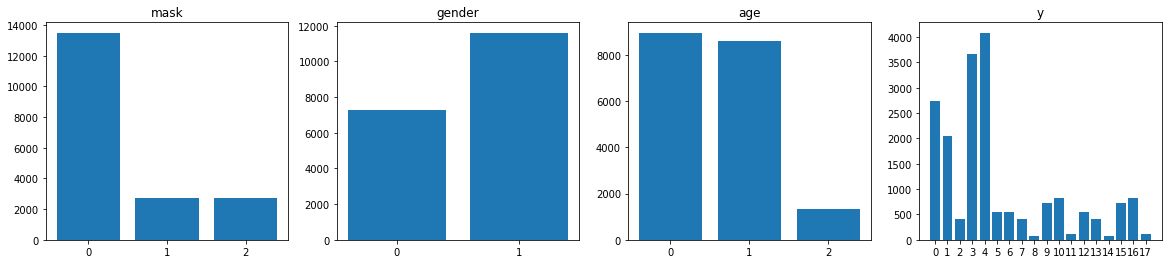

In [11]:
plt.figure(figsize=(20,4))

for i, x in enumerate(['mask', 'gender', 'age', 'y']):
    data = train_meta[x].value_counts()
    plt.subplot(1, 4, i+1)
    plt.bar(data.index, data.values, tick_label=data.index)
    plt.title(x);

## 1. Model 정의

In [12]:
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 2. Test Dataset 정의

In [13]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

## 3. Inference

In [14]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = MyModel(num_classes=18).to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
